# Flatiron Health mBC: Relaxed trials with GBM crude + dose correction 

***OBJECTIVE:*** **Reproduce CLEOPATRA trial while ensuring patients receiving chemotherapy are getting an  appropriate first dose. Inclusion criteria for these trials will be pragmatically relaxed to allow for entry of our real-world patients, many of which would not meet inclusion criteria in randomized controlled trials. Patients included in our trials will next be risk stratified using the gradient boosted model with crude imputation into 1 of 3 risk groups: high (top tertile), medium (middle tertile), and low (bottom tertile). Inverse-probability treatment weighted survival analysis will then be performed across these risk groups to get real-world estimates of survival while adjusting for measured confounders.** 

***OUTLINE:***
1. **Preprocessing**

2. **In-silico trials:**
* CLEOPATRA

## Part 1: Preprocessing

### 1.1 Import packages and create necessary functions

In [1]:
import numpy as np
import pandas as pd

from scipy import stats

from sksurv.nonparametric import kaplan_meier_estimator
from survive import KaplanMeier, SurvivalData

from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import median_survival_times

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.linear_model import LogisticRegression

from matplotlib.lines import Line2D   

In [2]:
# Function that returns number of rows and count of unique PatientIDs for a dataframe. 
def row_ID(dataframe):
    row = dataframe.shape[0]
    ID = dataframe['PatientID'].nunique()
    return row, ID

## Part 2: In silico trials 

### CLEOPATRA: pertuzumab, trastuzumab, and docetaxel in HER2-positive metastatic breast cancer

**INCLUSION**
* Untreated metastatic breast cancer
* Received first line pertuzumab, trastuzumab, and docetaxel/paclitaxel or first line trastuzumab + docetaxel/paclitaxel 
* First line of hormonal treatment is allowed
* HER-2 positive within (+30, -inf) of receipt of treatment 

#### First line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [3]:
df_full = pd.read_csv('df_risk_crude.csv', index_col = 'PatientID', dtype = {'death_status': bool})
df_full.index.nunique()

31677

In [4]:
line_therapy = pd.read_csv('LineOfTherapy.csv')

In [5]:
tpdp = [
    'Docetaxel,Pertuzumab,Trastuzumab',
    'Docetaxel,Pertuzumab,Trastuzumab-Anns',
    'Docetaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel,Pertuzumab,Trastuzumab',
    'Paclitaxel,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel,Pertuzumab,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Pertuzumab,Trastuzumab-Qyyp']

tpdp_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [6]:
tpdp_fl.loc[:, 'tpdp'] = 1

In [7]:
row_ID(tpdp_fl)

(1219, 1219)

In [8]:
tpd = [
    'Docetaxel,Trastuzumab',
    'Docetaxel,Trastuzumab-Anns',
    'Docetaxel,Trastuzumab-Qyyp',
    'Paclitaxel,Trastuzumab',
    'Paclitaxel,Trastuzumab-Anns',
    'Paclitaxel,Trastuzumab-Qyyp',
    'Paclitaxel Protein-Bound,Trastuzumab',
    'Paclitaxel Protein-Bound,Trastuzumab-Anns',
    'Paclitaxel Protein-Bound,Trastuzumab-Qyyp'] 

tpd_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1')
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [9]:
tpd_fl.loc[:, 'tpdp'] = 0

In [10]:
row_ID(tpdp_fl)

(1219, 1219)

#### First line endocrine therapy, second line trastuzumab + docetaxel/paclitaxel +/- pertuzumab 

In [11]:
all_treatment = line_therapy.LineName.unique()

In [12]:
treatment_list = []
for trt in all_treatment:
    treatment_list.extend(trt.split(","))

In [13]:
unique = list(dict.fromkeys(treatment_list))

In [14]:
et = [
    'Anastrozole',
    'Letrozole',
    'Exemestane',
    'Tamoxifen',
    'Leuprolide',
    'Goserelin',
    'Triptorelin']

In [15]:
unique.remove('Anastrozole')
unique.remove('Letrozole')
unique.remove('Exemestane')
unique.remove('Tamoxifen')
unique.remove('Leuprolide')
unique.remove('Goserelin')
unique.remove('Triptorelin')

In [16]:
line_therapy_fl = (
    line_therapy[line_therapy['PatientID'].isin(df_full.index)]
    .query('LineNumber == 1'))

In [17]:
(
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .LineName.value_counts().head(10)
)

Anastrozole               2943
Letrozole                 2536
Tamoxifen                 1305
Exemestane                 780
Leuprolide                  77
Goserelin                   60
Leuprolide,Tamoxifen        56
Letrozole,Leuprolide        40
Goserelin,Tamoxifen         36
Anastrozole,Leuprolide      35
Name: LineName, dtype: int64

In [18]:
et_id = (
    line_therapy_fl
    [line_therapy_fl['LineName'].str.contains('|'.join(et))
     & ~line_therapy_fl['LineName'].str.contains('|'.join(unique))]
    .PatientID
)

In [19]:
line_therapy_sec = (
    line_therapy[line_therapy['PatientID'].isin(et_id)]
    .query('LineNumber == 2'))

In [20]:
et_tpdp = (
    line_therapy_sec
    .query('LineName == @tpdp')
    [['PatientID', 'StartDate']]
)

In [21]:
et_tpdp.loc[:, 'tpdp'] = 1

In [22]:
row_ID(et_tpdp)

(79, 79)

In [23]:
et_tpd = (
    line_therapy_sec
    .query('LineName == @tpd')
    [['PatientID', 'StartDate']]
)

In [24]:
et_tpd.loc[:, 'tpdp'] = 0

In [25]:
row_ID(et_tpd)

(5, 5)

In [26]:
cleopatra_p = pd.concat([tpdp_fl, et_tpdp])

In [27]:
row_ID(cleopatra_p)

(1298, 1298)

In [28]:
cleopatra_np = pd.concat([tpd_fl, et_tpd])

In [29]:
row_ID(cleopatra_np)

(184, 184)

In [30]:
cleopatra = pd.concat([cleopatra_p, cleopatra_np])

In [31]:
row_ID(cleopatra)

(1482, 1482)

In [32]:
cleopatra = pd.merge(cleopatra, df_full, on = 'PatientID', how = 'inner')

In [33]:
row_ID(cleopatra)

(1482, 1482)

#### Docetaxel/Paclitaxel dosing

In [34]:
med_order = pd.read_csv('MedicationOrder.csv', low_memory = False)

In [35]:
med_order['ExpectedStartDate'] = np.where(med_order['ExpectedStartDate'].isna(), 
                                          med_order['OrderedDate'], 
                                          med_order['ExpectedStartDate'])

In [36]:
med_order.loc[:, 'ExpectedStartDate'] = pd.to_datetime(med_order['ExpectedStartDate'])

In [37]:
cleopatra['StartDate'] = pd.to_datetime(cleopatra['StartDate'])

In [38]:
med_order_dotx = (
    med_order[med_order['PatientID'].isin(cleopatra.PatientID)]
    .query('CommonDrugName == "docetaxel" or CommonDrugName == "paclitaxel"')
)

In [39]:
med_order_dotx.shape

(18649, 19)

In [40]:
med_order_dotx = pd.merge(med_order_dotx, 
                          cleopatra[['PatientID', 'StartDate']], 
                          on = 'PatientID', 
                          how = 'left')

In [41]:
med_order_dotx.shape

(18649, 20)

In [42]:
med_order_dotx.loc[:, 'date_diff'] = (med_order_dotx['ExpectedStartDate'] - med_order_dotx['StartDate']).dt.days.abs()

In [43]:
med_order_dotx = med_order_dotx.query('date_diff <= 14')

In [44]:
dotx_index = med_order_dotx.groupby('PatientID')['date_diff'].idxmin()

In [45]:
dotx_dose = med_order_dotx.loc[dotx_index].query('RelativeOrderedUnits == "mg/m2"')[['PatientID', 'RelativeOrderedAmount']]

In [46]:
dotx_dose = dotx_dose.rename(columns = {'RelativeOrderedAmount': 'dotx_dose_mgm2'})

In [47]:
dotx_IDs = dotx_dose.query('dotx_dose_mgm2 >= 75').PatientID

In [48]:
cleopatra = cleopatra[cleopatra['PatientID'].isin(dotx_IDs)]

#### HER-2 positive

In [49]:
biomarkers = pd.read_csv('Enhanced_MetBreastBiomarkers.csv')

In [50]:
biomarkers = biomarkers[biomarkers['PatientID'].isin(cleopatra['PatientID'])]

In [51]:
row_ID(biomarkers)

(7412, 1011)

In [52]:
biomarkers = pd.merge(biomarkers, cleopatra[['PatientID', 'StartDate']], on = 'PatientID', how = 'left')

In [53]:
row_ID(biomarkers)

(7412, 1011)

In [54]:
biomarkers['StartDate'] = pd.to_datetime(biomarkers['StartDate'])

In [55]:
biomarkers['ResultDate'] = pd.to_datetime(biomarkers['ResultDate'])

In [56]:
biomarkers['SpecimenReceivedDate'] = pd.to_datetime(biomarkers['SpecimenReceivedDate'])

In [57]:
biomarkers.loc[:, 'result_date'] = (
    np.where(biomarkers['ResultDate'].isna(), biomarkers['SpecimenReceivedDate'], biomarkers['ResultDate'])
)

In [58]:
biomarkers.loc[:, 'date_diff'] = (biomarkers['result_date'] - biomarkers['StartDate']).dt.days

In [59]:
her2_rel = ['IHC negative (0-1+)',
            'FISH negative/not amplified',
            'Negative NOS',
            'NGS negative (ERBB2 not amplified)',
            'IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

her2_status = (
    biomarkers
    .query('BiomarkerName == "HER2"')
    .query('date_diff <= 30')
    .query('BiomarkerStatus == @her2_rel')
    .sort_values(['PatientID', 'date_diff'], ascending = [True, False])
    .drop_duplicates(subset = ['PatientID'], keep = 'first')
    [['PatientID', 'BiomarkerStatus']]
    .rename(columns = {'BiomarkerStatus': 'her2'})
)

In [60]:
row_ID(her2_status)

(968, 968)

In [61]:
cleopatra = pd.merge(cleopatra, her2_status, on  = 'PatientID', how = 'left')

In [62]:
row_ID(cleopatra)

(1011, 1011)

In [63]:
her2_pos = ['IHC positive (3+)',
            'FISH positive/amplified',
            'Positive NOS',
            'NGS positive (ERBB2 amplified)']

cleopatra = (
    cleopatra
    .query('her2== @her2_pos')
)

In [64]:
row_ID(cleopatra)

(921, 921)

#### Time from treatment to death or censor 

In [65]:
mortality_tr = pd.read_csv('mortality_cleaned_tr.csv')

In [66]:
mortality_te = pd.read_csv('mortality_cleaned_te.csv')

In [67]:
mortality_tr = mortality_tr[['PatientID', 'death_date', 'last_activity']]

In [68]:
mortality_te = mortality_te[['PatientID', 'death_date', 'last_activity']]

In [69]:
mortality = pd.concat([mortality_tr, mortality_te], ignore_index = True)
row_ID(mortality)

(31677, 31677)

In [70]:
mortality.loc[:, 'last_activity'] = pd.to_datetime(mortality['last_activity'])

In [71]:
mortality.loc[:, 'death_date'] = pd.to_datetime(mortality['death_date'])

In [72]:
row_ID(mortality)

(31677, 31677)

In [73]:
cleopatra = pd.merge(cleopatra, mortality, on = 'PatientID', how = 'left')

In [74]:
row_ID(cleopatra)

(921, 921)

In [75]:
conditions = [
    (cleopatra['death_status'] == 1),
    (cleopatra['death_status'] == 0)]

choices = [
    (cleopatra['death_date'] - cleopatra['StartDate']).dt.days,
    (cleopatra['last_activity'] - cleopatra['StartDate']).dt.days]

cleopatra.loc[:, 'timerisk_treatment'] = np.select(conditions, choices)

In [76]:
cleopatra = cleopatra.query('timerisk_treatment >= 0')

#### Patient count 

In [77]:
low_cutoff_cleopatra = cleopatra.risk_score.quantile(1/3)

In [78]:
high_cutoff_cleopatra = cleopatra.risk_score.quantile(2/3)

In [79]:
print('Pertuzumab + trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 1').shape[0])
print('High risk:', cleopatra.query('tpdp == 1').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 1').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 1').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Pertuzumab + trastuzumab + docetaxel/paclitaxel total: 833
High risk: 269
Med risk: 283
Low risk: 281


In [80]:
print('Trastuzumab + docetaxel/paclitaxel total:',  cleopatra.query('tpdp == 0').shape[0])
print('High risk:', cleopatra.query('tpdp == 0').query('risk_score >= @high_cutoff_cleopatra').shape[0])
print('Med risk:', cleopatra.query('tpdp == 0').query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra').shape[0])
print('Low risk:', cleopatra.query('tpdp == 0').query('risk_score <= @low_cutoff_cleopatra').shape[0])

Trastuzumab + docetaxel/paclitaxel total: 87
High risk: 38
Med risk: 23
Low risk: 26


#### Survival curves with covaraite balancing 

In [81]:
conditions = [
    (cleopatra['thorax_met'] == 1) |
    (cleopatra['liver_met'] == 1) |
    (cleopatra['cns_met'] == 1) |
    (cleopatra['peritoneum_met'] == 1) |
    (cleopatra['other_met'] == 1),
    (cleopatra['bone_met'] == 0) &
    (cleopatra['thorax_met'] == 0) &
    (cleopatra['lymph_met'] == 0) &
    (cleopatra['liver_met'] == 0) &
    (cleopatra['cns_met'] == 0) &
    (cleopatra['skin_met'] == 0) &
    (cleopatra['peritoneum_met'] == 0) &
    (cleopatra['other_met'] == 0)
]

choices = ['visceral', 'unknown']

cleopatra['met_site'] = np.select(conditions, choices, default = 'nonvisceral')

In [82]:
cleopatra['met_cat'] = pd.cut(cleopatra['met_year'],
                              bins = [2010, 2016, float('inf')],
                              labels = ['11-16', '17-22'])

In [83]:
conditions = [
    ((cleopatra['ecog_diagnosis'] == "1.0") | (cleopatra['ecog_diagnosis'] == "0.0")),  
    ((cleopatra['ecog_diagnosis'] == "2.0") | (cleopatra['ecog_diagnosis'] == "3.0"))
]

choices = ['lt_2', 'gte_2']

cleopatra['ecog_2'] = np.select(conditions, choices, default = 'unknown')

In [84]:
conditions = [
    ((cleopatra['ses'] == 1) | (cleopatra['ses'] == 2) | (cleopatra['ses'] == 3)), 
    ((cleopatra['ses'] == 4) | (cleopatra['ses'] == 5))
]

choices = ['lt_4', 'gte_4']

cleopatra['ses_cat'] = np.select(conditions, choices, default = 'unknown')

In [85]:
cleopatra['race_cat'] = np.where(cleopatra['race'] == "White", 1, 0)

In [86]:
cleopatra = cleopatra.set_index('PatientID')

In [87]:
cleopatra_iptw = cleopatra.filter(items = ['death_status',
                                           'timerisk_treatment',
                                           'tpdp',
                                           'age',
                                           'gender',
                                           'race_cat',
                                           'p_type',
                                           'delta_met_diagnosis',
                                           'met_cat',
                                           'ses_cat',
                                           'ecog_2',
                                           'risk_score'])

In [88]:
cleopatra_iptw.dtypes

death_status               bool
timerisk_treatment      float64
tpdp                      int64
age                       int64
gender                   object
race_cat                  int64
p_type                   object
delta_met_diagnosis       int64
met_cat                category
ses_cat                  object
ecog_2                   object
risk_score              float64
dtype: object

In [89]:
to_be_categorical = list(cleopatra_iptw.select_dtypes(include = ['object']).columns)

In [90]:
to_be_categorical

['gender', 'p_type', 'ses_cat', 'ecog_2']

In [91]:
to_be_categorical.append('met_cat')

In [92]:
to_be_categorical.append('race_cat')

In [93]:
# Convert variables in list to categorical.
for x in list(to_be_categorical):
    cleopatra_iptw[x] = cleopatra_iptw[x].astype('category')

In [94]:
# List of numeric variables, excluding binary variables. 
numerical_features = ['age', 'delta_met_diagnosis']

# Transformer will first calculate column median and impute, and then apply a standard scaler. 
numerical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median')),
    ('std_scaler', StandardScaler())])

In [95]:
# List of categorical features.
categorical_features = list(cleopatra_iptw.select_dtypes(include = ['category']).columns)

# One-hot-encode categorical features.
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

In [96]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder = 'passthrough')

In [97]:
cleopatra_iptw_low = (
    cleopatra_iptw
    .query('risk_score <= @low_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_med = (
    cleopatra_iptw
    .query('risk_score < @high_cutoff_cleopatra and risk_score > @low_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_high = (
    cleopatra_iptw
    .query('risk_score >= @high_cutoff_cleopatra')
    .drop(columns = ['risk_score']))

cleopatra_iptw_all = (
    cleopatra_iptw
    .drop(columns = ['risk_score']))

In [98]:
cleopatra_low_x = preprocessor.fit_transform(cleopatra_iptw_low.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat',
                                                                                'ecog_2']))

cleopatra_med_x = preprocessor.fit_transform(cleopatra_iptw_med.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat', 
                                                                                'ecog_2']))

cleopatra_high_x = preprocessor.fit_transform(cleopatra_iptw_high.filter(items = ['age',
                                                                                  'gender',
                                                                                  'race_cat',
                                                                                  'p_type',
                                                                                  'delta_met_diagnosis',
                                                                                  'met_cat',
                                                                                  'ses_cat', 
                                                                                  'ecog_2']))

cleopatra_all_x = preprocessor.fit_transform(cleopatra_iptw_all.filter(items = ['age',
                                                                                'gender',
                                                                                'race_cat',
                                                                                'p_type',
                                                                                'delta_met_diagnosis',
                                                                                'met_cat',
                                                                                'ses_cat',
                                                                                'ecog_2']))

In [99]:
lr_cleopatra_low = LogisticRegression(max_iter = 1000)
lr_cleopatra_low.fit(cleopatra_low_x, cleopatra_iptw_low['tpdp'])

LogisticRegression(max_iter=1000)

In [100]:
lr_cleopatra_med = LogisticRegression(max_iter = 1000)
lr_cleopatra_med.fit(cleopatra_med_x, cleopatra_iptw_med['tpdp'])

LogisticRegression(max_iter=1000)

In [101]:
lr_cleopatra_high = LogisticRegression(max_iter = 1000)
lr_cleopatra_high.fit(cleopatra_high_x, cleopatra_iptw_high['tpdp'])

LogisticRegression(max_iter=1000)

In [102]:
lr_cleopatra_all = LogisticRegression(max_iter = 1000)
lr_cleopatra_all.fit(cleopatra_all_x, cleopatra_iptw_all['tpdp'])

LogisticRegression(max_iter=1000)

In [103]:
pred_low = lr_cleopatra_low.predict_proba(cleopatra_low_x)
pred_med = lr_cleopatra_med.predict_proba(cleopatra_med_x)
pred_high = lr_cleopatra_high.predict_proba(cleopatra_high_x)
pred_all = lr_cleopatra_all.predict_proba(cleopatra_all_x)

In [104]:
cleopatra_iptw_low['ps'] = pred_low[:, 1]
cleopatra_iptw_med['ps'] = pred_med[:, 1]
cleopatra_iptw_high['ps'] = pred_high[:, 1]
cleopatra_iptw_all['ps'] = pred_all[:, 1]

In [105]:
cleopatra_iptw_low['weight'] = (
    np.where(cleopatra_iptw_low['tpdp'] == 1, 1/cleopatra_iptw_low['ps'], 1/(1 - cleopatra_iptw_low['ps'])))

cleopatra_iptw_med['weight'] = (
    np.where(cleopatra_iptw_med['tpdp'] == 1, 1/cleopatra_iptw_med['ps'], 1/(1 - cleopatra_iptw_med['ps'])))

cleopatra_iptw_high['weight'] = (
    np.where(cleopatra_iptw_high['tpdp'] == 1, 1/cleopatra_iptw_high['ps'], 1/(1 - cleopatra_iptw_high['ps'])))

cleopatra_iptw_all['weight'] = (
    np.where(cleopatra_iptw_all['tpdp'] == 1, 1/cleopatra_iptw_all['ps'], 1/(1 - cleopatra_iptw_all['ps'])))

In [106]:
# Low KM curves
kmf_low_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_low_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_low_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_low.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_low.query('tpdp == 1')['death_status'],
    weights = cleopatra_iptw_low.query('tpdp == 1')['weight'])

kmf_low_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_low.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_low.query('tpdp == 0')['death_status'],
    weights = cleopatra_iptw_low.query('tpdp == 0')['weight'])

# Med KM curves
kmf_med_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_med_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_med_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_med.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_med.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_med.query('tpdp == 1')['weight'])

kmf_med_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_med.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_med.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_med.query('tpdp == 0')['weight'])

# High KM curves 
kmf_high_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_high_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_high_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_high.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_high.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_high.query('tpdp == 1')['weight'])

kmf_high_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_high.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_high.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_high.query('tpdp == 0')['weight'])

# All KM curves 
kmf_all_tpdp_cleopatra_iptw = KaplanMeierFitter()
kmf_all_tdp_cleopatra_iptw = KaplanMeierFitter()

kmf_all_tpdp_cleopatra_iptw.fit(
    cleopatra_iptw_all.query('tpdp == 1')['timerisk_treatment']/30,
    cleopatra_iptw_all.query('tpdp == 1')['death_status'], 
    weights = cleopatra_iptw_all.query('tpdp == 1')['weight'])

kmf_all_tdp_cleopatra_iptw.fit(
    cleopatra_iptw_all.query('tpdp == 0')['timerisk_treatment']/30,
    cleopatra_iptw_all.query('tpdp == 0')['death_status'], 
    weights = cleopatra_iptw_all.query('tpdp == 0')['weight'])

/Users/xavierorcutt/Dropbox/ist_project/myenv/lib/python3.7/site-packages/lifelines/fitters/kaplan_meier_fitter.py:344: StatisticalWarning: It looks like your weights are not integers, possibly propensity scores then?
  It's important to know that the naive variance estimates of the coefficients are biased. Instead use Monte Carlo to
  estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"
  or "Adjusted Kaplan-Meier estimator and log-rank test with inverse probability of treatment weighting for survival data."
                  
  StatisticalWarning,


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 889.803 total observations, 310.451 right-censored observations>

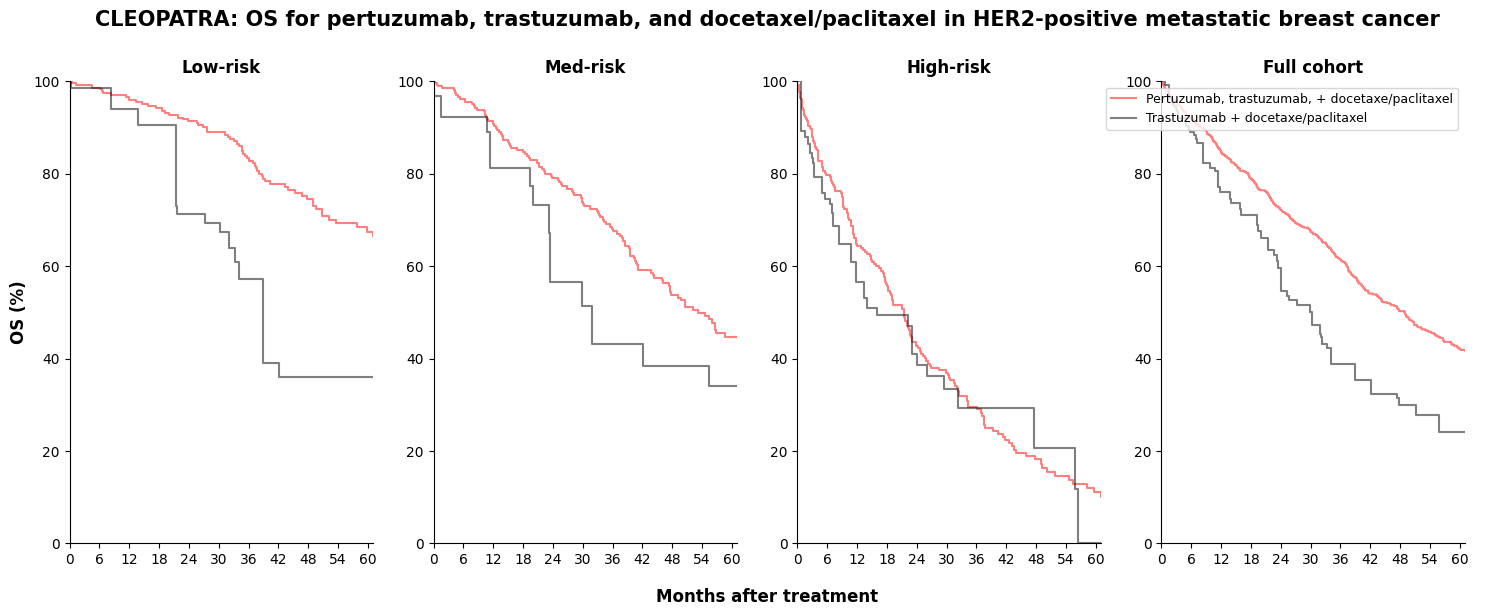

In [107]:
fig = plt.figure(figsize=(18, 6))

# Plot survival curves for low risk group 
plt.subplot(1, 4, 1)

plt.step(kmf_low_tpdp_cleopatra_iptw.timeline, kmf_low_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_low_tdp_cleopatra_iptw.timeline, kmf_low_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Low-risk', weight = 'bold')
plt.ylabel('OS (%)', size = 12, weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves for med risk group. 
plt.subplot(1, 4, 2)

plt.step(kmf_med_tpdp_cleopatra_iptw.timeline, kmf_med_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_med_tdp_cleopatra_iptw.timeline, kmf_med_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Med-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for high risk group. 
plt.subplot(1, 4, 3)

plt.step(kmf_high_tpdp_cleopatra_iptw.timeline, kmf_high_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5)

plt.step(kmf_high_tdp_cleopatra_iptw.timeline, kmf_high_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('High-risk', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Plot survival curves by treatment for all risk group. 
plt.subplot(1, 4, 4)

plt.step(kmf_all_tpdp_cleopatra_iptw.timeline, kmf_all_tpdp_cleopatra_iptw.survival_function_.values*100, color = 'red', alpha = 0.5, label = 'Pertuzumab, trastuzumab, + docetaxe/paclitaxel')

plt.step(kmf_all_tdp_cleopatra_iptw.timeline, kmf_all_tdp_cleopatra_iptw.survival_function_.values*100, color = 'black', alpha = 0.5, label = 'Trastuzumab + docetaxe/paclitaxel')

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)
plt.ylim(0, 100)

plt.title('Full cohort', weight = 'bold')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(loc = 'upper right', prop = {'size': 9})

fig.add_subplot(1, 1, 1, frameon = False)
plt.tick_params(labelcolor = 'none', which = 'both', top = False, bottom = False, left = False, right = False)
plt.xlabel('Months after treatment', labelpad = 15, size = 12, weight = 'bold')
plt.title('CLEOPATRA: OS for pertuzumab, trastuzumab, and docetaxel/paclitaxel in HER2-positive metastatic breast cancer', pad = 40, size = 15, weight = 'bold')

plt.show()